In [2]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
# with open('data/text_data/anna.txt', 'r') as f:

    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [2]:
# Model or Network
import impl.layer as l

class GRU:
    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for layer in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.copy()
            dXs.append(dX)
                
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [3]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):

    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    idx = 0
    state = nn.initial_state()
    smooth_loss = 1 # -np.log(1.0 / len(set(X_train)))
    eps = 1e-8
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, 100)
            print(sample)

    return nn

In [ ]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 1000 # epochs
alpha = 1e-3 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-1 loss: 51.8655
h, but PtojMie to her sus, and
theresse and has did dividen innilion ands
wribereds Ri neardif posidi
Iter-2 loss: 47.9406
h feels unbellial. A
straig I
formly spupor
mistreast othe coustration at Former, Rikua-Gutend covity
Iter-3 loss: 45.8223
he came for Projudiaic
repatecticimy
Pyotr unday. Thy Pyonch?" (Ans evioution distraptical thought.
A
Iter-4 loss: 49.8928
he papision. This the occuses put she work)
previded?. Sfulling Project-Dorctivitch and
set
him.
Serd
Iter-5 loss: 50.6754
hick- of this offeten priace ant meook in ago
merc. The guest more or please as the saps from been po
Iter-6 loss: 49.5593
he works
at Gutor disting ut
one
Grigais very soams has no to tifte, drept Stive Fyozs Oblonsky unmos
Iter-7 loss: 48.9011
h intertaken, Limer (Stringkions and Ig no, Lrying Nach Engle so a vietion matterome you saw that he 
Iter-8 loss: 48.3412
him_, much
is without go one flaise. If avisting a carch such is my windown trudation
of
people of yo
Iter-9 loss: 49.

Iter-10 loss: 69.7389
en
of in The Noly cerisy and and' axIg lasexa ans in eron onst Ind Seror of the WNresturoly ffyd roll
Iter-20 loss: 55.2252
expand. an ea Aan 8ind an in, the and Dhi walliilg asjivesid c8Snike opuIc meopeality Nilion ofx Seal
Iter-30 loss: 44.8632
e coumhina in fed or serouldg Emiwal bollours land ra im 35 intain, Okhos the meed the G7s.) Japan is
Iter-40 loss: 36.7176
e toplogirg a bo the nomy perbing militerui and Wing prough haghessurures entcen, Sha, the OUpse ahes
Iter-50 loss: 30.7191
er wart in the world's turmea. Japan is atyo licallire barly a Enstury. Japan was prorlat expacleobar
Iter-60 loss: 24.5414
e tot hed the 186688 Sine courthe Ultured in the Uppex. inslefecered in hectirest. Japdatiom of Nito 
Iter-70 loss: 18.9626
ed fith nas uron is an's highesost bolsateriand Silekeatud and 7uthan Brst. The core. Japan is thitt 
Iter-80 loss: 15.5075
ed cing the ing satil Sede
 Japan ors82 Sudor and apac eson the UAsu, isolaturize. in alithic perea a
Iter-90 

Iter-680 loss: 1.6969
e north to the East China Sea and Taiwan in the south. The kanji that make up Japan's name mean "sun 
Iter-690 loss: 1.6888
e north to the East China Sea and Taiwan in the south. The kanji that make up Japan's name mean "sun 
Iter-700 loss: 1.6838
e world's ang suunat is and Horras, in the suctylis feved conskokur and isevenses ferckount 4Drh ands
Iter-710 loss: 1.6793
er and Winter Olympic Games.
. Japan (Japanese: 日本 Nippon or Nihon; formally. About this sound Nippon
Iter-720 loss: 1.6754
ered into a long period of isolation in the early 17th century, which was ended in 1853 when a United
Iter-730 loss: 1.6713
ered into a long period of isolation in the early 17th century, which was ended in 1853 when a United
Iter-740 loss: 1.6688
er and Winter Olympic Games.
. btule cita amilulec enpecliconston the Unt inte he tor enjim liol teto
Iter-750 loss: 1.6670
er and Winter Olympic Games.
..
 ulereevend Japanese: 日本 Nipan e ston Wive, th w parld Wawd of The fo
Iter-760

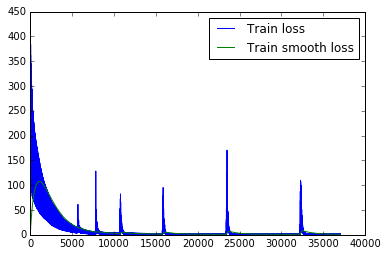

In [7]:
# # Hyper-parameters
# time_step = 100 # width, minibatch size and test sample size as well
# num_layers = 2 # depth
# n_iter = 1000 # epochs
# alpha = 1e-3 # learning_rate
# p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
# print_after = 10 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # Build the network and learning it or optimizing it using SGD
# net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
#           p_dropout=p_dropout)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()

Iter-10 loss: 80.8186
enia FhlleMof "unor es ryrty RAroury. Japintolrel bosth a3 coan Okexcin corled Han bohe iNthita mand 
Iter-20 loss: 69.5554
exof pars im, Woped lar, Japen's Warury 1855 and in the Sed byrsoukou, the fitrtopa, fysh aed pace ds
Iter-30 loss: 60.0279
econa Napand Hofillifito intth ended Ginbal the Narg croc was the wored m7in tha Japan, 47, aigedingo
Iter-40 loss: 50.9462
e the Rishat of Wortgerit opld and. "Tites rinsy cinsta. Japane"d asklallolyt Chine, an olitition eno
Iter-50 loss: 44.6376
erlante corat Ching Kortholy bygs as lounstarly, the Indevcomomally-seceoat of G本, Japan end Naipa, K
Iter-60 loss: 40.2347
e hirgitan ruked ind Irea, whisi ceatdliol of 7iand, meiclito-JappabanonMic tas ranges thint ardes um
Iter-70 loss: 35.5851
erited in the Gloungid mike op enie tstedext ryss andic makE rons Ariam. Lowut rodeht Uip1lanth-itopr
Iter-80 loss: 32.1593
e porun the y. hyril 1"855 whins fortd narea ded fsture poveld. Japaneas 2018, wheve Sea a. 120 intop
Iter-90 

Iter-670 loss: 2.6075
e forrth in 1868 ardional Diet baldex. The wurud. The Sian contorid constitrthico Japanese Warke gins
Iter-680 loss: 2.4936
ed firltwulihe foust firhturally in 1st cansed fortomed Japan ta, with to the comportes a diving coke
Iter-690 loss: 2.4074
e world's largest metropolitan arke was inte peoflal aivhe aiverceke peried inter centroWes nareast w
Iter-700 loss: 9.5475
empon earlakione cokode first in the East Chino Seaia aed asd vorte nater OE's sureationy cottopin 18
Iter-710 loss: 3.4840
e mornd is a med bomperiof of the Easi aree nulconele torag larde tred curection follobed largest mil
Iter-720 loss: 2.7747
ered into a long perbose narghmicedece eleoti. The populapimake bales, constituted firt the world, an
Iter-730 loss: 2.4924
e world's nemporeede efeat the wionte nwwopre by fures andesef with the world's erouncland Imand Sian
Iter-740 loss: 2.3336
e tory third-lare as inter and it porulcD ind 6smand country wat tulal Dilal Dleol the soutot perine 
Iter-750

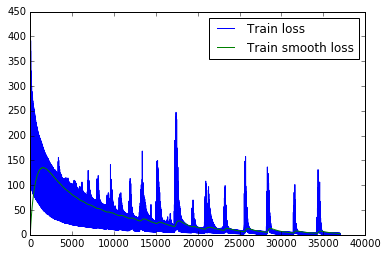

In [6]:
# # Hyper-parameters
# time_step = 100 # width, minibatch size and test sample size as well
# num_layers = 1 # depth
# n_iter = 1000 # epochs
# alpha = 1e-3 # learning_rate
# p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
# print_after = 10 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # Build the network and learning it or optimizing it using SGD
# net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
#           p_dropout=p_dropout)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()